
📚 Fold 1


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

✅ Weights loaded from model_deit_tuning.pth



📚 Fold 2
✅ Weights loaded from model_deit_tuning.pth



📚 Fold 3
✅ Weights loaded from model_deit_tuning.pth



📚 Fold 4
✅ Weights loaded from model_deit_tuning.pth



📚 Fold 5
✅ Weights loaded from model_deit_tuning.pth



🏆 Best Fold: Fold 2 with Accuracy 0.9927


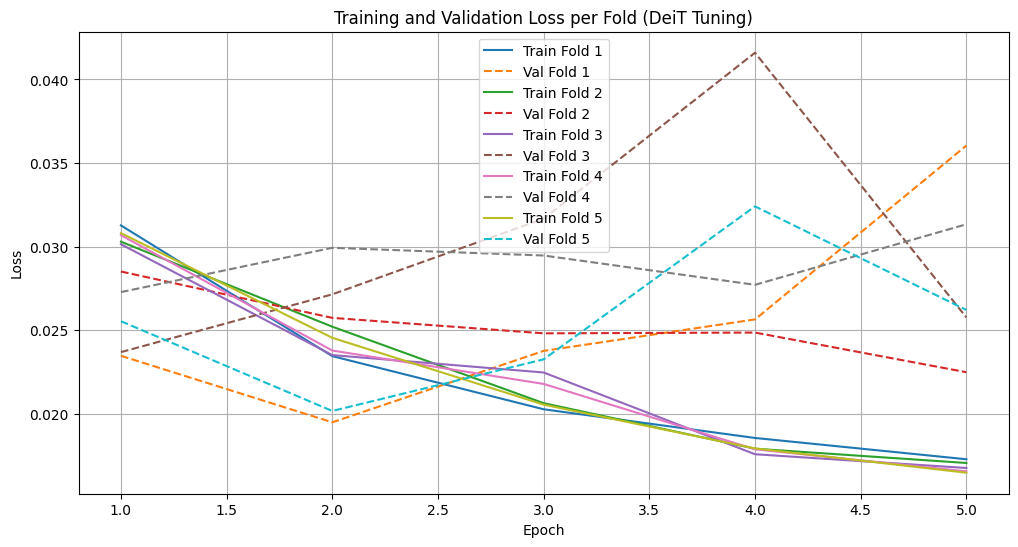

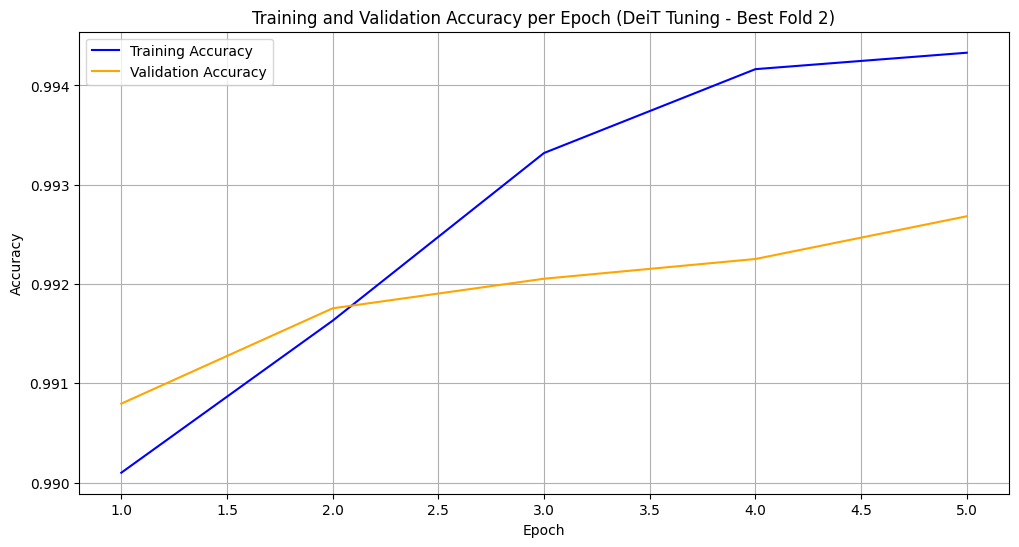

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from timm import create_model
from torch.cuda.amp import autocast, GradScaler

# Dataset dan transform
train_dir = "/workspace/dataset_vit_aug1/dataset_vit_aug/train"
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
labels = train_dataset.targets
classes = train_dataset.classes

n_splits = 5
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "model_deit_tuning.pth"
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

all_reports = []
fold_losses = []
train_accuracies_all = []
val_accuracies_all = []

def calculate_specificity_sensitivity(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))
    metrics = {}
    for i, label in enumerate(labels):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        sensitivity = TP / (TP + FN) if TP + FN != 0 else 0
        specificity = TN / (TN + FP) if TN + FP != 0 else 0
        metrics[label] = {'sensitivity': sensitivity, 'specificity': specificity}
    return metrics

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
    print(f"\n📚 Fold {fold + 1}")

    train_loader = DataLoader(Subset(train_dataset, train_idx), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(Subset(train_dataset, val_idx), batch_size=batch_size, shuffle=False)

    model = create_model("deit_base_patch16_224", pretrained=True, num_classes=0)
    model.head = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(model.num_features, len(classes))
    )
    try:
        model.load_state_dict(torch.load(model_path))
        print(f"✅ Weights loaded from {model_path}")
    except Exception as e:
        print(f"⚠️ Failed to load weights: {e} — lanjut training dari awal.")

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scaler = GradScaler()

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(5):
        model.train()
        correct_train = total_train = 0
        running_loss = 0.0
        loop = tqdm(train_loader, desc=f"Fold {fold+1} | Epoch {epoch+1}/5", leave=False)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)
            loop.set_postfix(loss=loss.item())
        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        correct_val = total_val = 0
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

    fold_losses.append((train_losses, val_losses))
    train_accuracies_all.append(train_accuracies)
    val_accuracies_all.append(val_accuracies)

    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels.cpu().numpy())

    report = classification_report(y_true, y_pred, output_dict=True, target_names=classes)
    accuracy = accuracy_score(y_true, y_pred)
    sensi_speci = calculate_specificity_sensitivity(y_true, y_pred, classes)

    all_reports.append({
        'fold': fold + 1,
        'accuracy': accuracy,
        'report': report,
        'sensi_speci': sensi_speci
    })

# ====== Step 7: Simpan Evaluasi ke CSV ======
rows = []
for res in all_reports:
    for cls in classes:
        rep = res['report'][cls]
        sens = res['sensi_speci'][cls]
        rows.append({
            'Fold': f"Fold {res['fold']}",
            'Class': cls,
            'Accuracy': round(res['accuracy'], 4),
            'Precision': round(rep['precision'], 4),
            'Recall': round(rep['recall'], 4),
            'F1-Score': round(rep['f1-score'], 4),
            'Support': rep['support'],
            'Sensitivity': round(sens['sensitivity'], 4),
            'Specificity': round(sens['specificity'], 4),
        })
pd.DataFrame(rows).to_csv("kfold_deit_tuning_metrics.csv", index=False)

summary = []
for res in all_reports:
    macro = res['report']['macro avg']
    summary.append({
        'Fold': f"Fold {res['fold']}",
        'Accuracy': round(res['accuracy'], 4),
        'Macro Precision': round(macro['precision'], 4),
        'Macro Recall': round(macro['recall'], 4),
        'Macro F1-Score': round(macro['f1-score'], 4)
    })
pd.DataFrame(summary).to_csv("summary_per_fold_deit_tuning.csv", index=False)

summary_full = []
for res in all_reports:
    rep = res['report']
    sens_spec = res['sensi_speci']
    precision_vals = [rep[c]['precision'] for c in classes]
    recall_vals = [rep[c]['recall'] for c in classes]
    f1_vals = [rep[c]['f1-score'] for c in classes]
    sensitivities = [v['sensitivity'] for v in sens_spec.values()]
    specificities = [v['specificity'] for v in sens_spec.values()]
    summary_full.append({
        'Fold': f"Fold {res['fold']}",
        'Accuracy': round(res['accuracy'], 6),
        'Precision': round(np.mean(precision_vals), 6),
        'Sensitivity': round(np.mean(sensitivities), 6),
        'Specificity': round(np.mean(specificities), 6),
        'F1-Score': round(np.mean(f1_vals), 6),
    })
pd.DataFrame(summary_full).to_csv("summary_fold_all_metrics_deit_tuning.csv", index=False)

# ====== Step 8: Best Fold ======
best_fold = max(all_reports, key=lambda x: x['accuracy'])
print(f"\n🏆 Best Fold: Fold {best_fold['fold']} with Accuracy {best_fold['accuracy']:.4f}")

best_rows = []
for cls in classes:
    best_rows.append({
        'Class': cls,
        'Precision': round(best_fold['report'][cls]['precision'], 4),
        'Sensitivity': round(best_fold['sensi_speci'][cls]['sensitivity'], 4),
        'Specificity': round(best_fold['sensi_speci'][cls]['specificity'], 4),
        'F1-Score': round(best_fold['report'][cls]['f1-score'], 4)
    })
pd.DataFrame(best_rows).to_csv("best_fold_class_metrics_deit_tuning.csv", index=False)

# ====== Step 9: Plot Loss ======
plt.figure(figsize=(12, 6))
for i, (train_loss, val_loss) in enumerate(fold_losses):
    plt.plot(range(1, len(train_loss)+1), train_loss, label=f"Train Fold {i+1}")
    plt.plot(range(1, len(val_loss)+1), val_loss, linestyle='--', label=f"Val Fold {i+1}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Fold (DeiT Tuning)")
plt.legend()
plt.grid(True)
plt.savefig("deit_tuning_loss_plot.png")
plt.show()

# ====== Step 10: Plot Accuracy (Best Fold) ======
best_fold_index = best_fold['fold'] - 1
plt.figure(figsize=(12, 6))
plt.plot(range(1, 6), train_accuracies_all[best_fold_index], label='Training Accuracy', color='blue')
plt.plot(range(1, 6), val_accuracies_all[best_fold_index], label='Validation Accuracy', color='orange')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"Training and Validation Accuracy per Epoch (DeiT Tuning - Best Fold {best_fold_index + 1})")
plt.legend()
plt.grid(True)
plt.savefig(f"deit_tuning_best_fold{best_fold_index + 1}_accuracy.png")
plt.show()


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
from timm import create_model

# ====== Device Setup ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"📟 Device: {device}")

# ====== Load Dataset ======
test_dir = "dataset_vit/test"
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
dataset = datasets.ImageFolder(test_dir, transform=transform)
labels = dataset.targets
classes = dataset.classes
print(f"🧪 Total Data: {len(dataset)} samples")
print(f"📂 Classes: {classes}")

# ====== K-Fold Config ======
n_splits = 5
batch_size = 32
model_path = "model_deit_tuning.pth"
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# ====== Fungsi Hitung Sensitivity & Specificity ======
def calculate_specificity_sensitivity(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))
    metrics = {}
    for i, label in enumerate(labels):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        sensitivity = TP / (TP + FN) if TP + FN != 0 else 0
        specificity = TN / (TN + FP) if TN + FP != 0 else 0
        metrics[label] = {'sensitivity': sensitivity, 'specificity': specificity}
    return metrics

# ====== Step 1: Evaluasi K-Fold ======
all_reports = []

for fold, (_, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
    print(f"\n📚 Fold {fold + 1}")
    val_subset = Subset(dataset, val_idx)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Load DeiT Model with Tuning
    model = create_model("deit_base_patch16_224", pretrained=True, num_classes=0)
    model.head = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(model.num_features, len(classes))
    )
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()

    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels_batch in tqdm(val_loader, desc=f"Evaluating Fold {fold+1}"):
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels_batch.numpy())

    report = classification_report(y_true, y_pred, output_dict=True, target_names=classes)
    accuracy = accuracy_score(y_true, y_pred)
    sensi_speci = calculate_specificity_sensitivity(y_true, y_pred, classes)

    all_reports.append({
        'fold': fold + 1,
        'accuracy': accuracy,
        'report': report,
        'sensi_speci': sensi_speci,
        'y_true': y_true,
        'y_pred': y_pred
    })

# ====== Step 2: Detail Evaluasi per Fold per Kelas ======
rows = []
for fold_result in all_reports:
    fold = fold_result['fold']
    report = fold_result['report']
    sensi_speci = fold_result['sensi_speci']
    acc = fold_result['accuracy']
    for cls in classes:
        rows.append({
            'Fold': f"Fold {fold}",
            'Class': cls,
            'Accuracy': round(acc, 4),
            'Precision': round(report[cls]['precision'], 4),
            'Recall': round(report[cls]['recall'], 4),
            'F1-Score': round(report[cls]['f1-score'], 4),
            'Sensitivity': round(sensi_speci[cls]['sensitivity'], 4),
            'Specificity': round(sensi_speci[cls]['specificity'], 4),
            'Support': report[cls]['support']
        })
df_detail = pd.DataFrame(rows)
os.makedirs("results_eval_kfold_deit_tuned", exist_ok=True)
df_detail.to_csv("results_eval_kfold_deit_tuned/kfold_detail_deit_tuned.csv", index=False)

# ====== Step 3: Ringkasan per Fold (Macro Avg) ======
summary_per_fold = []
for result in all_reports:
    macro = result['report']['macro avg']
    summary_per_fold.append({
        'Fold': f"Fold {result['fold']}",
        'Accuracy': round(result['accuracy'], 4),
        'Macro Precision': round(macro['precision'], 4),
        'Macro Recall': round(macro['recall'], 4),
        'Macro F1-Score': round(macro['f1-score'], 4)
    })
df_summary = pd.DataFrame(summary_per_fold)
df_summary.to_csv("results_eval_kfold_deit_tuned/kfold_summary_deit_tuned.csv", index=False)

# ====== Step 4: Ringkasan Lengkap Rata-Rata Tiap Fold ======
summary_table = []
for result in all_reports:
    fold = result['fold']
    rep = result['report']
    sensi_speci = result['sensi_speci']
    precision_vals = [rep[cls]['precision'] for cls in classes]
    recall_vals = [rep[cls]['recall'] for cls in classes]
    f1_vals = [rep[cls]['f1-score'] for cls in classes]
    sensitivities = [v['sensitivity'] for v in sensi_speci.values()]
    specificities = [v['specificity'] for v in sensi_speci.values()]
    summary_table.append({
        'Fold': f"Fold {fold}",
        'Accuracy': round(result['accuracy'], 6),
        'Precision': round(np.mean(precision_vals), 6),
        'Sensitivity': round(np.mean(sensitivities), 6),
        'Specificity': round(np.mean(specificities), 6),
        'F1-Score': round(np.mean(f1_vals), 6)
    })
df_all_summary = pd.DataFrame(summary_table)
df_all_summary.to_csv("results_eval_kfold_deit_tuned/kfold_full_summary_deit_tuned.csv", index=False)

# ====== Step 5: Fold Terbaik dan Confusion Matrix ======
best_fold = max(all_reports, key=lambda x: x['accuracy'])
print(f"\n🏆 Fold terbaik: Fold {best_fold['fold']} dengan akurasi {best_fold['accuracy']:.4f}")

# Simpan Metrik Kelas dari Fold Terbaik
best_rows = []
for cls in classes:
    best_rows.append({
        'Class': cls,
        'Precision': round(best_fold['report'][cls]['precision'], 4),
        'Sensitivity': round(best_fold['sensi_speci'][cls]['sensitivity'], 4),
        'Specificity': round(best_fold['sensi_speci'][cls]['specificity'], 4),
        'F1-Score': round(best_fold['report'][cls]['f1-score'], 4)
    })
df_best = pd.DataFrame(best_rows)
df_best.to_csv("results_eval_kfold_deit_tuned/best_fold_class_metrics_deit_tuned.csv", index=False)

# Confusion Matrix Fold Terbaik
cm = confusion_matrix(best_fold['y_true'], best_fold['y_pred'])
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - Fold {best_fold['fold']} (DeiT Tuned)")
plt.tight_layout()
plt.savefig(f"results_eval_kfold_deit_tuned/confusion_matrix_fold_{best_fold['fold']}_deit_tuned.png")
plt.close()
print(f"🖼️ Confusion matrix disimpan ke: results_eval_kfold_deit_tuned/confusion_matrix_fold_{best_fold['fold']}_deit_tuned.png")


c:\Users\pravi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


📟 Device: cuda
🧪 Total Data: 33335 samples
📂 Classes: ['A', 'AFIB', 'AFL', 'L', 'N', 'R', 'V']

📚 Fold 1


Evaluating Fold 1: 100%|██████████| 209/209 [01:22<00:00,  2.53it/s]



📚 Fold 2


Evaluating Fold 2: 100%|██████████| 209/209 [01:27<00:00,  2.39it/s]



📚 Fold 3


Evaluating Fold 3: 100%|██████████| 209/209 [01:44<00:00,  2.00it/s]



📚 Fold 4


Evaluating Fold 4: 100%|██████████| 209/209 [01:24<00:00,  2.48it/s]



📚 Fold 5


Evaluating Fold 5: 100%|██████████| 209/209 [01:21<00:00,  2.55it/s]



🏆 Fold terbaik: Fold 1 dengan akurasi 0.9894
🖼️ Confusion matrix disimpan ke: results_eval_kfold_deit_tuned/confusion_matrix_fold_1_deit_tuned.png


In [1]:
pip install matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 66.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 kB 902.7 kB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 6.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 72.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 71.4 kB/s eta 0:00:000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 35.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 812.3 kB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 11.5 MB/s eta 0:00:0000:0100:01m

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 16.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 458.5 kB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install torch torchvision torchaudio


[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 126.2 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 4.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install numpy


[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install timm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 44.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.4/515.4 kB 2.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 3.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 71.8 MB/s eta 0:00:0000:01
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.4.0
    Uninstalling fsspec-2023.4.0:
      Successfully uninstalled fsspec-2023.4.0

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
